<a href="https://colab.research.google.com/github/NoahGruenert/Bananalyzer/blob/main/Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Bananalyzer Model 1.0
This project will be the initial model that can determine banana ripeness when given an image.
Workflow:
1.   Accept dataset of banana images for training, validation, and testing
2.   Initialize a model that can classify images as banana or not banana, with a confidence interval
3. If banana, designate ripeness (on a 1-10 scale?), with a confidence interval



Begin by importing TensorFlow and initializing the ResNet50 image classification model.
We need this model because we will not be training our model from scratch to identify objects in images. We instead use transfer learning to begin with this general-purpose image classification model, and then add additional layers to fine-tune the model for our Bananas.

Here's the original paper that explains Residual Networks and why they are useful. https://arxiv.org/pdf/1512.03385

Here's a great video that explains them on a more basic level:  https://www.youtube.com/watch?v=o_3mboe1jYI

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Freeze the model so we dont retrain any of the image classification parts we got from ResNet.

In [7]:
for layer in base_model.layers:
        layer.trainable = False

Then we create our own layers atop this frozen model, so we can specialize the image classification model to be used only for classifying Bananas.


In [8]:
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
    from tensorflow.keras.models import Model

    num_classes = 9 # Day 1-8, + 0: not a banana

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)                        #Rectified Linear Unit is a good activation function for our final Dense layer
    predictions = Dense(num_classes, activation='softmax')(x)   #Softmax is the activation function for our final classification

    model = Model(inputs=base_model.input, outputs=predictions)

Let's provide the dataset for our Banananylsis.
Using this publicly available dataset from Anish Kumar, we will train our model to recognize 9 kinds of images.

0, Not a Banana, and 1 - 8 which represent how many days are left before this banana spoils.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil
import zipfile

local_zip = '/content/NoahsBananaData.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')

# 1. Load the labels from the CSV file
df = pd.read_csv('/content/NoahsBananaData/banana_days_531_synced.csv')


# 2. Extract features (image_filename) and target (label)
X = df['image_filename']
y = df['days_left']

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,         # 30% of data goes to temporary pool, which we will then split into testing and validation sets
    random_state=42,
    stratify=y
)

In [4]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,         # 50% of the 30% temp pool = 15% of total
    random_state=42,
    stratify=y_temp
)

In [5]:
# Create the main directories for the split
base_dir = 'banana_dataset_split'
os.makedirs(base_dir, exist_ok=True)
os.makedirs(os.path.join(base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test'), exist_ok=True)

original_image_folder = '/content/NoahsBananaData/banana_images_jpg'

# Function to move files
def move_files(filenames, set_name):
    print(f"Moving {len(filenames)} files to the {set_name} set...")
    set_df = df[df['image_filename'].isin(filenames)]

    for _, row in set_df.iterrows():
        # Get the class name (or convert the label number to a string/name)
        class_name = str(row['days_left'])

        # Create the class directory if it doesn't exist
        class_dir = os.path.join(base_dir, set_name, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Define source and destination paths
        src = os.path.join(original_image_folder, row['image_filename'])
        dst = os.path.join(class_dir, row['image_filename'])

        # Move the file
        shutil.copy(src, dst) # Use shutil.move if you want to save space

# Move the files for each set
move_files(X_train.tolist(), 'train')
move_files(X_val.tolist(), 'validation')
move_files(X_test.tolist(), 'test')

print("\n--- Split Complete ---")
print("Your dataset is ready in the 'banana_dataset_split' folder.")

Moving 371 files to the train set...
Moving 80 files to the validation set...
Moving 80 files to the test set...

--- Split Complete ---
Your dataset is ready in the 'banana_dataset_split' folder.


Now that we have our data, we can begin training our new model on it!

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255
)

validation_datagen = ImageDataGenerator(
      rescale=1./255
)

test_datagen = ImageDataGenerator(
      rescale=1./255
)

TRAIN_DIRECTORY_LOCATION = '/content/banana_dataset_split/train'
VAL_DIRECTORY_LOCATION = '/content/banana_dataset_split/validation'
TEST_DIRECTORY_LOCATION = '/content/banana_dataset_split/test'
TARGET_SIZE = (224, 224)
CLASS_MODE = 'categorical'

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIRECTORY_LOCATION,
    target_size = TARGET_SIZE,
    batch_size = 64,
    class_mode = CLASS_MODE
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_DIRECTORY_LOCATION,
    target_size = TARGET_SIZE,
    batch_size = 64,
    class_mode = CLASS_MODE
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIRECTORY_LOCATION,
    target_size = TARGET_SIZE,
    batch_size = 64,
    class_mode = CLASS_MODE
)

Found 371 images belonging to 9 classes.
Found 80 images belonging to 9 classes.
Found 80 images belonging to 9 classes.


Now we will compile and train the model.
Let's use an Adam optimizer and a categorical crossentropy loss function because we have discrete categories for our data.

In [10]:
model.summary() #Just to take a peek at the model first before we begin training

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,145 (90.98 MB)

 Trainable params: 263,433 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    NUM_EPOCHS = 12 #12 is too few

    history = model.fit(
      train_generator,
      epochs = NUM_EPOCHS,
      verbose = 1,
      validation_data = validation_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 97s 16s/step - accuracy: 0.1635 - loss: 2.2538 - val_accuracy: 0.1125 - val_loss: 2.2200
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 81s 14s/step - accuracy: 0.1478 - loss: 2.2048 - val_accuracy: 0.1875 - val_loss: 2.1506
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 80s 14s/step - accuracy: 0.2098 - loss: 2.1306 - val_accuracy: 0.1500 - val_loss: 2.1357
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 14s/step - accuracy: 0.2387 - loss: 2.0854 - val_accuracy: 0.1375 - val_loss: 2.1288
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 14s/step - accuracy: 0.2147 - loss: 2.0938 - val_accuracy: 0.1875 - val_loss: 2.1257
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 13s/step - accuracy: 0.2197 - loss: 2.0490 - val_accuracy: 0.1500 - val_loss: 2.1255
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 14s/step - accuracy: 0.2311 - loss: 2.1026 - val_accuracy: 0.2000 - val_loss: 2.1148
Epoch 8/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 13s/step - accuracy: 0.2327 - loss: 2.0499 - val_accuracy: 0.2250 - val_loss: 2.1169


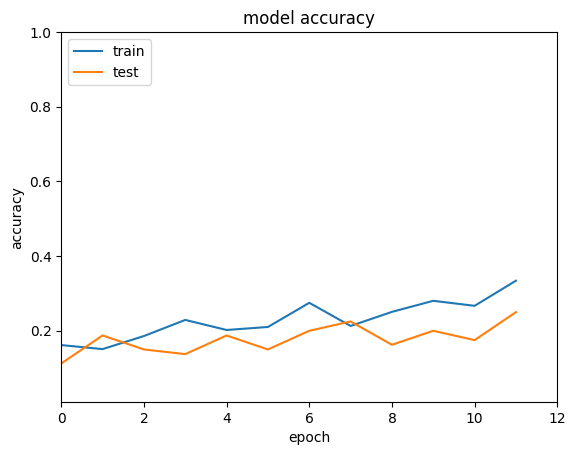

In [15]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim([0,NUM_EPOCHS])
plt.ylim([0.01,1.0])
plt.show()